In [1]:
# !pip install -Uqq fastai 
# import zipfile
# import os
from fastai.vision.all import *
from pathlib import Path

In [2]:
path = Path("/data/datasets/severstal")
# os.chdir(path)

In [3]:
# !kaggle competitions download -c severstal-steel-defect-detection

In [4]:
# zf_path = path / "severstal-steel-defect-detection.zip"
# with zipfile.ZipFile(zf_path, 'r') as zip_ref:
#     zip_ref.extractall(path)

In [5]:
path.ls()

(#7) [Path('/data/datasets/severstal/severstal-steel-defect-detection.zip'),Path('/data/datasets/severstal/codes.txt'),Path('/data/datasets/severstal/sample_submission.csv'),Path('/data/datasets/severstal/test_images'),Path('/data/datasets/severstal/train.csv'),Path('/data/datasets/severstal/train_images'),Path('/data/datasets/severstal/masks')]

In [6]:
df = pd.read_csv(path/'train.csv')
df.head(3)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 38863 28 39119 28 39375 29 39631 29 39887 29 40143 29 40399 29 40655 30 40911 30 41167 30 41423 30 41679 31 41935 31 42191 31 42447 31 42703 31 42960 31 43216 31 43472 31 43728 31 43984 31 44240 32 44496 32 44752 32 45008 32 45264 33 45520 33 45776 33 46032 33 46288 33 46544 34 46803 31 47065 25 47327 19 47588 15 47850 9 48112 3 62667 12 62923 23 63179 23 63348 3 63435 23 63604 7 63691 23 63860 11 63947 23 64116 15 64203 23 64372 19 64459 23 64628 24 64715 23 64884 28 64971 23 65139 33 65227 23 65395 37 65483 23 65651 41 65740 22 65907 45 65996 22...


In [7]:
def generate_masks():
    im_sz = (1600, 256)
    for fn in get_image_files(path/'train_images'):
        im = np.zeros(im_sz[0]*im_sz[1], dtype=np.uint8)
        for c in range(1, 5):
            rle_pixels = df[(df["ImageId"]==fn.name) & (df["ClassId"]==c)]["EncodedPixels"].values
            if len(rle_pixels) > 0:
                rle_numbers = [int(numstring) for numstring in rle_pixels[0].split(' ')]
                rle_pairs = np.array(rle_numbers).reshape(-1, 2)
                for index, length in rle_pairs:
                    index -= 1
                    im[index:index+length] = c
        im = Image.fromarray(im.reshape(im_sz).T)
        im.save(path/'masks'/f"{fn.stem}.png")
        
# generate_masks()

**Create codes.txt file in the same folder**
1. Background
2. Divots
3. Cracks
4. Scratches
5. Ablations

In [8]:
codes = ["Background", "Divots", "Cracks", "Scratches", "Ablation"]

In [54]:
dblock = DataBlock(blocks=(ImageBlock(PILImageBW), MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y = lambda o: path/'masks'/f'{o.stem}.png',
                   item_tfms=RandomResizedCrop(256, min_scale=0.3)
)

In [57]:
dls=dblock.dataloaders(path/'train_images', bs=4)

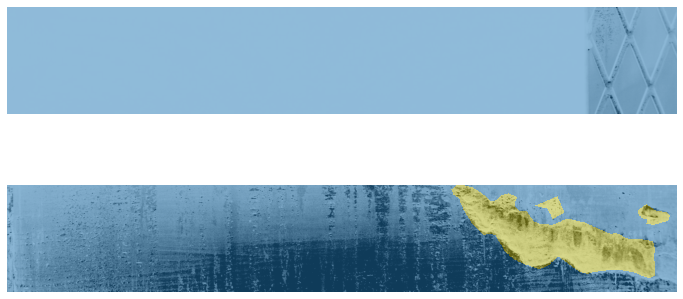

In [34]:
dls.valid.show_batch(max_n=2, nrows=2, figsize=(12,6))

In [35]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 1, 256, 1600]), torch.Size([8, 256, 1600]))

#### Confirming masks are decoded properly for defect classes

In [59]:
masks = get_image_files(path/'masks')
maxes = [np.max(array(Image.open(m))) for m in masks]
np.unique(maxes, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=uint8), array([5902,  769,  230, 4866,  801]))

#### Training simple unet model

In [58]:
learn = unet_learner(dls, resnet18, opt_func=RAdam, metrics=[Dice])
learn.fine_tune(1)

epoch,train_loss,valid_loss,dice,time
0,0.143315,0.146507,0.083041,06:08


epoch,train_loss,valid_loss,dice,time
0,0.097548,0.251881,0.807252,06:24


In [7]:
from fastai.vision.all import *
t = tensor([1,2,3],[4,5,6],[7,8,9]); t.shape, t

(torch.Size([3, 3]),
 tensor([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]))

In [12]:
tqdm(t.squeeze(1))

NameError: name 'tqdm' is not defined